In [196]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [206]:
# Pre configure modules
sns.set_context("notebook")

In [94]:
# Import data, remove duplicates and set index
data = pd.read_csv('data/device_failure.csv', parse_dates=['date'], encoding='ISO-8859-1')
data.drop_duplicates(inplace=True)
data.set_index(['device', 'date'], inplace=True)

# Rename / Reorder columns, asssign target and features
data.columns = [c.replace('attribute', 'm') if c != 'failure' else c for c in data.columns]
target_col =  'failure'
feature_cols = sorted(list(set(data.columns) - set([target_col])))
data = data[feature_cols + [target_col]]

# Print head
data.head()

,,m1,m2,m3,m4,m5,m6,m7,m8,m9,failure
device,date,,,,,,,,,,
S1F01085,2015-01-01,215630672,56,0,52,6,407438,0,0,7,0
S1F0166B,2015-01-01,61370680,0,3,0,6,403174,0,0,0,0
S1F01E6Y,2015-01-01,173295968,0,0,0,12,237394,0,0,0,0
S1F01JE0,2015-01-01,79694024,0,0,0,6,410186,0,0,0,0
S1F01R2B,2015-01-01,135970480,0,0,0,15,313173,0,0,3,0


In [324]:
# Function to get outliers according to IQR or Z score.
def get_outliers(d, method='IQR'):
    if method == 'IQR':
        q1, q3 = d.quantile(.25), d.quantile(.75)
        iqr = q3 - q1
        llim, ulim = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
    else:
        mean, std = d.mean(), d.std()
        llim, ulim = mean-(3*std), mean+(3*std)
    
    return (d < llim) | (d > ulim)

# Function to plot deatiled view for a column    
def detail_plot(d, outliers=True):
    fig, axs = plt.subplots(2, 1, figsize=(20, 7), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

    sns.distplot(d, axlabel=False, ax=axs[0])
    
    if outliers:
        mean, std = d.mean(), d.std()
        llim, ulim = mean-(3*std), mean+(3*std)
    
        kde_x, kde_y = axs[0].lines[0].get_data()
        p1, p2 = axs[0].axvline(x=llim,color='red'), axs[0].axvline(x=ulim,color='red')
        axs[0].fill_between(kde_x, kde_y, where=(kde_x<llim) | (kde_x>ulim) , interpolate=True, color='#EF9A9A')

    sns.boxplot(d, ax=axs[1])
    plt.show()


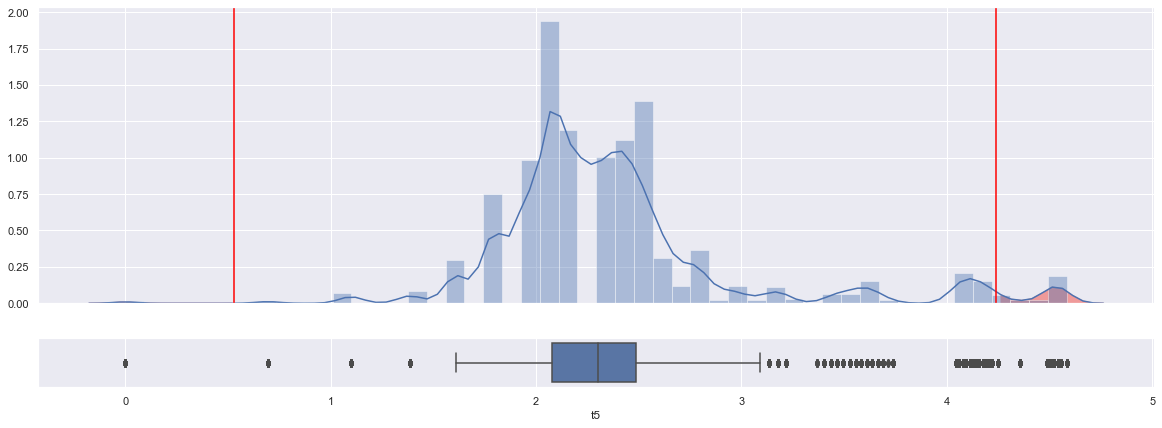

In [330]:
# Analize M5 Data
m = data[['m5']]
#detail_plot(m['m5'], outliers=False)

# Log Transform column to remove skew
m.insert(m.shape[1], 't5', np.log(m['m5']))
detail_plot(m['t5'], outliers=True)

# Mark outliers by IQR, Z score
m.insert(m.shape[1], 'ol_iqr',get_outliers(m['t5'], method='IQR'))
m.insert(m.shape[1], 'ol_z', get_outliers(m['t5'], method='Z'))

# Summarize outlier counts
ol_summary = pd.DataFrame([{'total': m.shape[0], 'z_count': m['ol_z'].sum(), 'iqr_count': m['ol_iqr'].sum()}])
ol_summary['z_pct'] = ol_summary['z_count'].div(ol_summary['total'], 2).mul(100).round(2)
ol_summary['iqr_pct'] = ol_summary['iqr_count'].div(ol_summary['total'], 2).mul(100).round(2)
